In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
!pip install python_speech_features
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import sys
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization,
    Conv2D, GlobalMaxPooling2D, Lambda, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Nadam
from python_speech_features import logfbank
import scipy.io.wavfile as wav

sys.path.append('/content/drive/MyDrive/mobilenets_py/resources/libraries')
import ei_tensorflow.training

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=330e571c7f71d17d3b2ec453cb7a08ab998fc70de0483fb263921740edc855a5
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/mobilenets_py/simon_classified'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

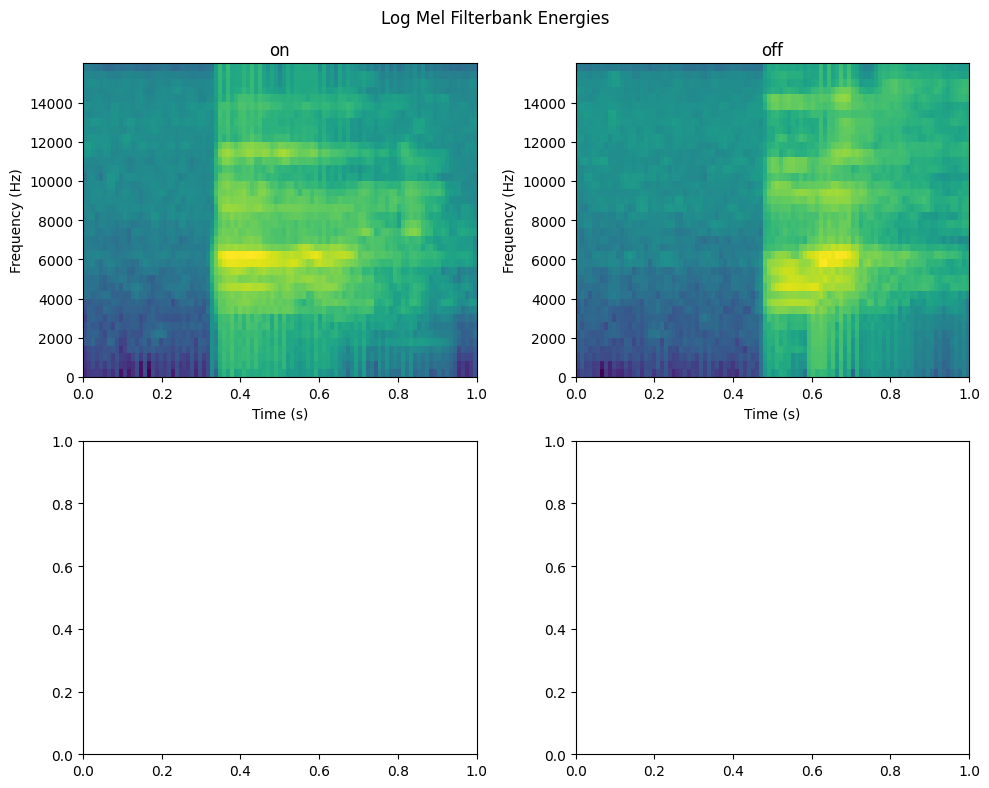

In [ ]:
# happy : 0a2b400e_nohash_0.wav
# others: 00b01445_nohash_0.wav
dir = ['marvin', 'eight', 'house', 'happy']
endpoint = ['00b01445_nohash_0.wav', '00b01445_nohash_0.wav', '00b01445_nohash_0.wav', '0a2b400e_nohash_0.wav']
# dir = ['on', 'off']
# endpoint = ['00b01445_nohash_0.wav', '00b01445_nohash_0.wav']
# Initialize the rate, sig, and fbank_feat lists
rate = []
sig = []
fbank_feat = []


# Loop through the iterations
for i in range(len(dir)):
    # Read the WAV file
    r, s = wav.read(f'{DATASET_PATH}/{dir[i]}/{endpoint[i]}')

    # Append the rate and sig to the respective lists
    rate.append(r)
    sig.append(s)

    # Calculate the log Mel filterbank energies
    fbank = logfbank(sig[i], rate[i], winlen=0.02, nfilt=40)

    # Append the fbank to the fbank_feat list
    fbank_feat.append(fbank)

# Create subplots in a 2x2 subfigure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Log Mel Filterbank Energies')

# Loop through the fbank_feat list and plot each subplot
for i in range(len(fbank_feat)):
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index

    num_frames, num_filterbanks = fbank_feat[i].shape
    duration = len(sig[i]) / rate[i]
    time_axis = np.linspace(0, duration, num_frames)
    filterbank_axis = np.arange(rate[i])

    axs[row, col].imshow(fbank_feat[i].T, aspect='auto', origin='lower', extent=[0, duration, filterbank_axis[0], filterbank_axis[-1]])
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Frequency (Hz)')
    axs[row, col].set_title(f'{dir[i]}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Entrenamiento MobileNets

In [3]:
# !pip install tflite
# !pip install onnx
# !pip install nvidia-pyindex
# !pip install onnx-graphsurgeon
# !pip install tensorflow-addons
# !pip install -e git+https://github.com/onnx/onnx-tensorflow.git#egg=onnx-tf
# !pip install akida
# !pip install cnn2snn
# !pip install tensorflow==2.11
# !pip install protobuf==3.20.0
# !pip install pynvml
# !pip install keras==2.10
# !pip install requests

data = '/content/drive/MyDrive/mobilenets_py/data_good/'
!python3 /content/drive/MyDrive/mobilenets_py/train.py \
   --info-file /content/drive/MyDrive/mobilenets_py/train_input.json\
   --data-directory {data}\
   --out-directory /content/drive/MyDrive/mobilenets_py/output_non_aug/\
   --epochs 30\
   --learning-rate 0.001


Training model...
Training on 5490 inputs, validating on 5490 inputs
Model: "mobilenetv2_0.35_99"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 99, 40, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 20, 16)   144         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 20, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 20, 16)   0           ['bn_Conv1[0][0]']               
          

# Gráficos MobileNet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

headers = ['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss']
df = pd.read_csv('/content/drive/MyDrive/mobilenets_py/artifacts/training_log.csv', names=headers)

x = df['epoch'][1:].values
y = df['loss'][1:].astype(float).values
z = df['val_loss'][1:].astype(float).values

v = df['accuracy'][1:].astype(float).values
w = df['val_accuracy'][1:].astype(float).values

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y, z)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(np.concatenate([y, z]))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss')
plt.grid(True)

# Mostrar el último valor en el gráfico de pérdida
plt.text(x[-1], y[-1], str(round(y[-1], 2)), ha='center', va='bottom')
plt.text(x[-1], z[-1], str(round(z[-1], 2)), ha='center', va='bottom')
plt.xticks(np.arange(0, len(x), 10))

plt.subplot(1, 2, 2)
plt.plot(x, 100 * np.array(v), 100 * np.array(w))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Mostrar el último valor en el gráfico de precisión
plt.text(x[-1], 100 * v[-1], str(round(100 * v[-1], 2)) + '%', ha='left', va='bottom')
plt.text(x[-1], 100 * w[-1], str(round(100 * w[-1], 2)) + '%', ha='right', va='bottom')
# Mostrar solo cada quinto número en el eje x
plt.xticks(np.arange(0, len(x), 10))

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/mobilenets_py/output/30epochs-LR001-non-augmented_really_not_augmented.png')

# Entrenamiento CNN - No utilizado para TFG


In [ ]:
#CNN Edge Impulse
data = '/content/drive/MyDrive/cnn/data/'
!python3 /content/drive/MyDrive/cnn/train.py \
   --info-file /content/drive/MyDrive/cnn/train_input.json\
   --data-directory {data}\
   --out-directory /content/drive/MyDrive/cnn/output/\
   --epochs 30\
   --learning-rate 0.001


Training model...
Training on 10642 inputs, validating on 2661 inputs
Epoch 1/30
Epoch 33% done
Epoch 67% done
333/333 - 31s - loss: 0.9606 - accuracy: 0.6534 - val_loss: 0.7525 - val_accuracy: 0.7313 - 31s/epoch - 92ms/step
Epoch 2/30
Epoch 32% done
Epoch 71% done
333/333 - 31s - loss: 0.7029 - accuracy: 0.7614 - val_loss: 0.6625 - val_accuracy: 0.7719 - 31s/epoch - 93ms/step
Epoch 3/30
Epoch 0% done
Epoch 33% done
Epoch 71% done
333/333 - 31s - loss: 0.6183 - accuracy: 0.7940 - val_loss: 0.6157 - val_accuracy: 0.7899 - 31s/epoch - 92ms/step
Epoch 4/30
Epoch 0% done
Epoch 33% done
Epoch 72% done
333/333 - 33s - loss: 0.5556 - accuracy: 0.8167 - val_loss: 0.5617 - val_accuracy: 0.8159 - 33s/epoch - 98ms/step
Epoch 5/30
Epoch 42% done
Epoch 73% done
333/333 - 29s - loss: 0.4993 - accuracy: 0.8347 - val_loss: 0.5309 - val_accuracy: 0.8241 - 29s/epoch - 87ms/step
Epoch 6/30
Epoch 0% done
Epoch 47% done
Epoch 73% done
333/333 - 28s - loss: 0.4598 - accuracy: 0.8472 - val_loss: 0.4912 - va

# Gráficos CNN - No utilizado para TFG

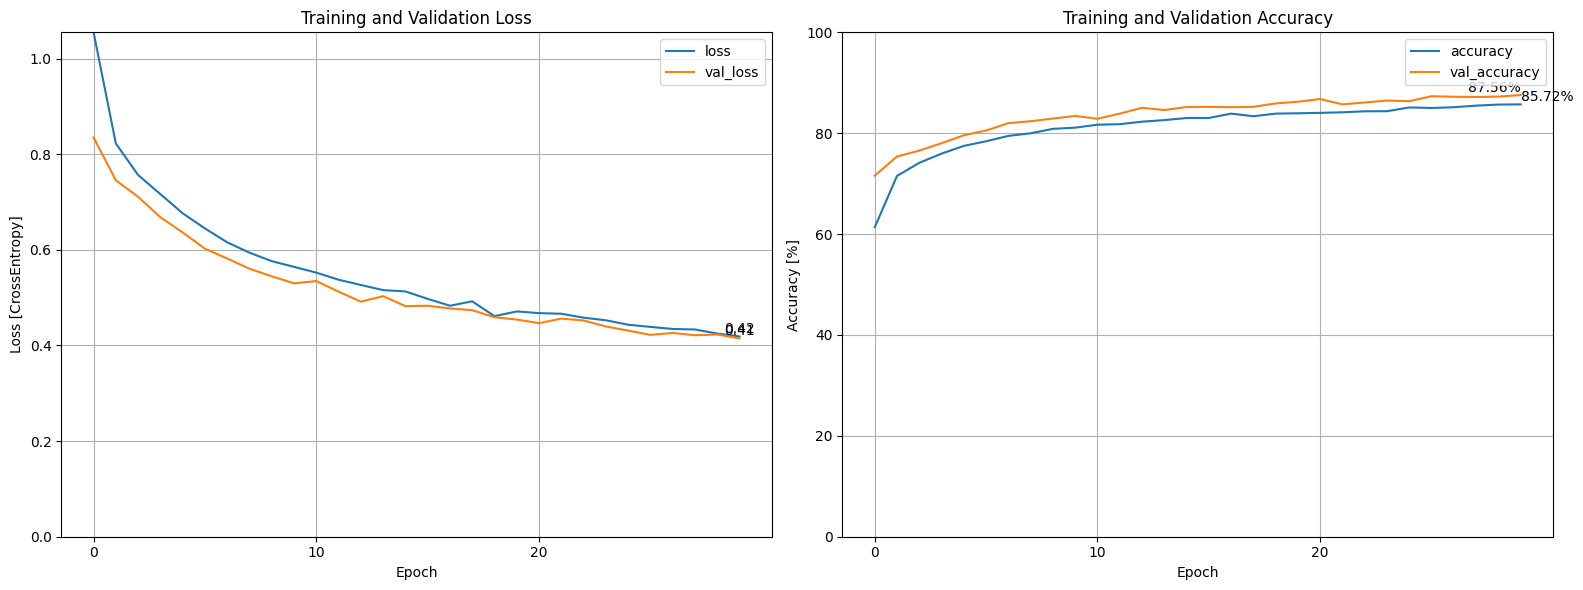

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

headers = ['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss']
df = pd.read_csv('/content/drive/MyDrive/cnn/artifacts/training_log.csv', names=headers)

x = df['epoch'][1:].values
y = df['loss'][1:].astype(float).values
z = df['val_loss'][1:].astype(float).values

v = df['accuracy'][1:].astype(float).values
w = df['val_accuracy'][1:].astype(float).values

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y, z)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(np.concatenate([y, z]))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss')
plt.grid(True)

# Mostrar el último valor en el gráfico de pérdida
plt.text(x[-1], y[-1], str(round(y[-1], 2)), ha='center', va='bottom')
plt.text(x[-1], z[-1], str(round(z[-1], 2)), ha='center', va='bottom')
plt.xticks(np.arange(0, len(x), 10))

plt.subplot(1, 2, 2)
plt.plot(x, 100 * np.array(v), 100 * np.array(w))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Mostrar el último valor en el gráfico de precisión
plt.text(x[-1], 100 * v[-1], str(round(100 * v[-1], 2)) + '%', ha='left', va='bottom')
plt.text(x[-1], 100 * w[-1], str(round(100 * w[-1], 2)) + '%', ha='right', va='bottom')
# Mostrar solo cada quinto número en el eje x
plt.xticks(np.arange(0, len(x), 10))

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/cnn/output/cnn_30epochs-LR001.png')


# Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
import tensorflow as tf
import numpy as np
# Load the tflite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/mobilenets_py/output_non_aug/model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the test data
x_test = np.load("/content/drive/MyDrive/mobilenets_py/data_good/X_split_test.npy")
y_test = np.load("/content/drive/MyDrive/mobilenets_py/data_good/Y_split_test.npy")

# Evaluate the model on test data
correct_predictions = 0
total_predictions = 0

for i in range(len(x_test)):
    x = np.expand_dims(x_test[i], axis=0)
    y_true = np.expand_dims(y_test[i], axis=0)
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    y_pred = np.argmax(output, axis=1)
    correct_predictions += int(y_pred == np.argmax(y_true))
    total_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Accuracy: 0.9666666666666667


In [ ]:
# import tensorflow as tf
# import numpy as np

# # # Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/mobilenets_py/output_non_aug/model.tflite")
interpreter.allocate_tensors()

# # # Get the input and output tensor details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]


# # Load your test data

# x_test = np.info('/content/drive/MyDrive/mobilenets_py/data_good/X_split_test.npy')
# y_test = np.info('/content/drive/MyDrive/mobilenets_py/data_good/Y_split_test.npy')

# # Create a dataset for prediction
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(1)

# # Make predictions on the dataset
predictions = []
for x, y in test_dataset:
    # Prepare the input tensor
    interpreter.set_tensor(input_details['index'], x)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output = interpreter.get_tensor(output_details['index'])

    # Add the predictions to the list
    predictions.append(output)

# Convert the list of predictions to a numpy array
predictions = np.concatenate(predictions, axis=0)

# Compute the evaluation metrics
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)
loss = -np.mean(np.log(predictions[np.arange(len(y_true)), y_true]))

# Print the evaluation metrics
print('Test accuracy:', accuracy)
print('Test loss:', loss)

Test accuracy: 0.9666666666666667
Test loss: 0.13627484


In [ ]:
print(y_test)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


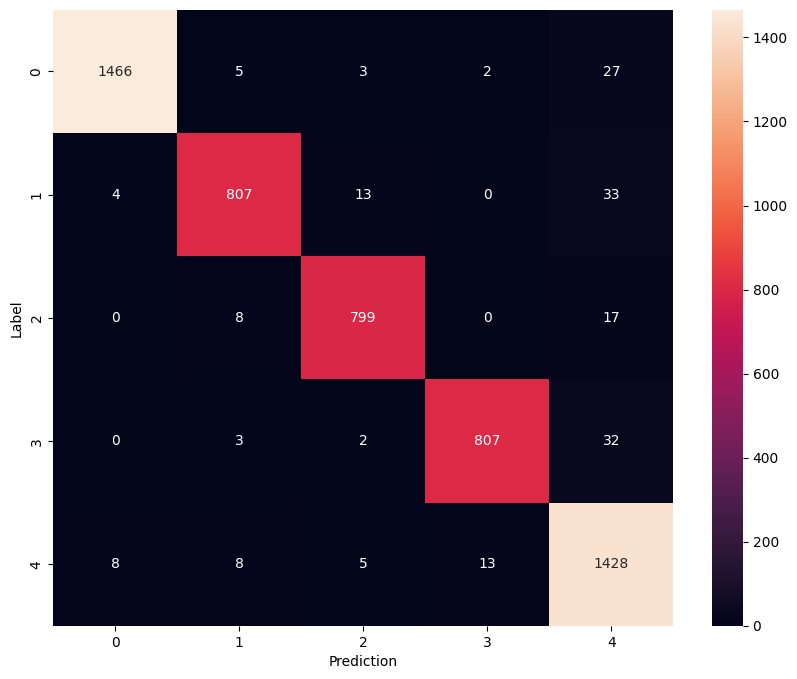

In [ ]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
# plt.savefig('/content/drive/MyDrive/mobilenets_py/output/figs/15epochs-marvin-confussion_matrix.png')